In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# tuning
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklego.meta import Thresholder

# set seed
np.random.seed(666)

In [74]:
df = pd.read_csv('hotel_bookings.csv')

## Cleaning and preparing

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Let's just drop company and agent column, since it won't be useful with building model anyway. There are some columns contaning missing values, such as contry column and children column. We will check them again after dropping the columns.

In [76]:
df.drop(columns=['company', 'agent'], inplace=True)

In [77]:
# Check missing valuse of country and children
print(f"Missing values in the children column : {df.children.isna().sum()}")
print(f"Missing values in the country column : {df.country.isna().sum()}")

Missing values in the children column : 4
Missing values in the country column : 488


Since it's just a small proportion comparing to the total rows, let's just drop the row with missing values right away.

In [78]:
df.dropna(inplace=True)

In [79]:
df.isna().sum().sum()

0

jjhgh### Numerical values
We will be using lead_time, total_of_special_requests, previous_cancellations, booking_changes as model features according to this correlation heat map 

<AxesSubplot:>

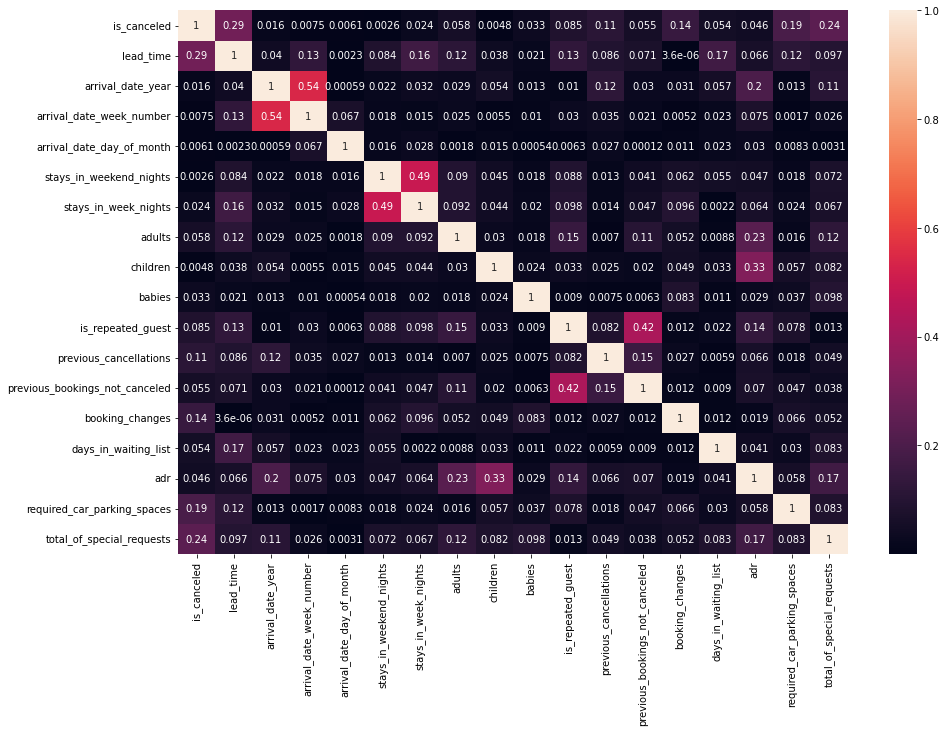

In [80]:
plt.figure(figsize=(15, 10))
sns.heatmap(abs(df.corr()), annot=True)

## Selecting features to build a model

In [81]:
# Random sampling 10% of the total data to increase speed of building models
df_sample = df.sample(frac=0.1, random_state=555)
# Select features to be in the model and divide them into categorical data and numerical data
cat_features = ['hotel', 'market_segment', 'previous_cancellations'] # Based on EDA analysis on a previous project
num_features = ['lead_time', 'total_of_special_requests', 'booking_changes']
used_features = cat_features + num_features
label = 'is_canceled'

## Build models
- logistic regression
- Decision tree
- KNN
- Random Forest
- Voting classfiers

In [82]:
# Train test split
train_x, test_x, train_y, test_y = train_test_split(df_sample[used_features], df_sample[label], test_size=0.2)

# Preprocessing
trans = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features),
    ('scale', StandardScaler(), num_features)
])

In [83]:
# Logistic regression
logit = Thresholder(LogisticRegression(max_iter = 1000), 0.5)
# Decision Tree
tree = DecisionTreeClassifier()
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
# Random forest
rf = RandomForestClassifier()
# Voting Classifiers
vt = VotingClassifier(estimators=[('logit',logit),('tree', tree), ('knn', knn), ('rf',rf)], voting='soft')

In [84]:
models = {'logit':logit,'tree':tree,'knn':knn,'rf':rf,'vt':vt}
for name, model in models.items():
    # Pipeline: combining preprocessing and modeling
    pipe_temp = Pipeline([
        ('transform', trans),
        (name, model)
    ])
    
    # Predicting and scoring
    y_pred = cross_val_predict(pipe_temp, train_x, train_y,  cv =5)
    result = cross_validate(pipe_temp, train_x, train_y, cv=5, scoring=['accuracy','precision','recall','f1'])
    print(name)
    print('ACC : ', result['test_accuracy'].mean())
    print('Precision :', result['test_precision'].mean())
    print('Recall :', result['test_recall'].mean())
    print('F1-score :', result['test_f1'].mean())

logit
ACC :  0.7399074348819977
Precision : 0.723583112146639
Recall : 0.5043119155565396
F1-score : 0.593572638821643
tree
ACC :  0.7447431224039965
Precision : 0.6829273159006178
Recall : 0.6049039832480585
F1-score : 0.6413704965461867
knn
ACC :  0.7568337226129754
Precision : 0.7004986742625204
Recall : 0.6227312812981978
F1-score : 0.6591388037974835
rf
ACC :  0.7535740512655595
Precision : 0.6854592376088461
Recall : 0.6427967040011188
F1-score : 0.6631210503898448
vt
ACC :  0.7673460411448414
Precision : 0.7173410696168214
Recall : 0.6341569445577557
F1-score : 0.672940134470586


F1-score of every model except the logistic regression are pretty close to each other (0.65-0.67). Let's try them on the test dataset to see if they're ovefitted or not.

In [85]:
for name,model in models.items():
    pipe_temp = Pipeline([
        ('transform', trans),
        (name, model)
    ])
    # Predict on the test data set
    pipe_temp.fit(train_x, train_y)
    pred_y = pipe_temp.predict(test_x)
    # Scoring test data set
    print(name)
    print(f"ACC: {accuracy_score(test_y, pred_y)}")
    print(f"Precision: {precision_score(test_y, pred_y)}")
    print(f"Recall: {recall_score(test_y, pred_y)}")
    print(f"F1-Score: {f1_score(test_y, pred_y)}")

logit
ACC: 0.7531539108494533
Precision: 0.7641357027463651
Recall: 0.5175054704595186
F1-Score: 0.6170906718851924
tree
ACC: 0.7472666105971405
Precision: 0.6993630573248407
Recall: 0.600656455142232
F1-Score: 0.646262507357269
knn
ACC: 0.7573591253153911
Precision: 0.7208387942332897
Recall: 0.6017505470459519
F1-Score: 0.655933214072749
rf
ACC: 0.7502102607232969
Precision: 0.6918465227817746
Recall: 0.6312910284463895
F1-Score: 0.6601830663615561
vt
ACC: 0.755677039529016
Precision: 0.7110266159695817
Recall: 0.6137855579868708
F1-Score: 0.6588373458602467


There were not much different between the result of test and train data set, so these models worked pretty well! Also the accuracy of all the models were very close to each other (75% +- 1).
<br> Let's use logistic regression since it's the one that simplest and fastest to train and optimize. </br>
Now I will train the logistic regression again and tune threshold of the logistic regression to find the best threshold that result to the highest accuracy and f1-score with GridSearchCV.

In [86]:
# Train the model again

# Pipeline
pipe = Pipeline([
    ('trans', trans),
    ('logit', logit)
])

# Threshold from 0.4 - 0.6 with 0.01 step
param = {'logit__threshold':np.arange(0.4,0.61,0.01) }
model = GridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv = 5,
    scoring = ['f1','precision','recall','accuracy'],
    refit = 'f1',
    verbose=2
)

# Train the model
model.fit(train_x, train_y)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END ...............................logit__threshold=0.4; total time=   0.0s
[CV] END ...............................logit__threshold=0.4; total time=   0.0s
[CV] END ...............................logit__threshold=0.4; total time=   0.0s
[CV] END ...............................logit__threshold=0.4; total time=   0.0s
[CV] END ...............................logit__threshold=0.4; total time=   0.0s
[CV] END ...............logit__threshold=0.41000000000000003; total time=   0.0s
[CV] END ...............logit__threshold=0.41000000000000003; total time=   0.0s
[CV] END ...............logit__threshold=0.41000000000000003; total time=   0.0s
[CV] END ...............logit__threshold=0.41000000000000003; total time=   0.0s
[CV] END ...............logit__threshold=0.41000000000000003; total time=   0.0s
[CV] END ...............logit__threshold=0.42000000000000004; total time=   0.0s
[CV] END ...............logit__threshold=0.4200

[CV] END ................logit__threshold=0.6000000000000002; total time=   0.0s
[CV] END ................logit__threshold=0.6000000000000002; total time=   0.0s
[CV] END ................logit__threshold=0.6000000000000002; total time=   0.0s
[CV] END ................logit__threshold=0.6000000000000002; total time=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['hotel',
                                                                          'market_segment',
                                                                          'previous_cancellations']),
                                                                        ('scale',
                                                                         StandardScaler(),
                                                                         ['lead_time',
                                                                          'total_of_special_requests',
                                                                          'booking_changes'])])),
                                       ('logit',
                                        Thresholder(model=LogisticRegression(max_iter=1000),
                                                    threshold=0.5))]),
             param_grid={'logit__threshold': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ])},
             refit='f1', scoring=['f1', 'precision', 'recall', 'accuracy'],
             verbose=2)

In [87]:
result = pd.DataFrame(model.cv_results_)
#result[['param_logit__threshold', '']]]
result_score = result[['param_logit__threshold','mean_test_recall','mean_test_f1', 'mean_test_precision','mean_test_accuracy']]
display(result_score)

,param_logit__threshold,mean_test_recall,mean_test_f1,mean_test_precision,mean_test_accuracy
0,0.4,0.672324,0.651874,0.632799,0.729183
1,0.41,0.657279,0.648055,0.639281,0.730760
2,0.42,0.644186,0.644883,0.645918,0.732442
3,0.43,0.624958,0.637241,0.650387,0.731706
4,0.44,0.610749,0.633109,0.657518,0.733073
5,0.45,0.594029,0.625532,0.661046,0.731812
6,0.46,0.579539,0.618895,0.664571,0.730970
7,0.47,0.564494,0.613628,0.672962,0.732022
8,0.48,0.548614,0.611686,0.692395,0.737489
9,0.49,0.526323,0.603560,0.709290,0.739592


Well, now we see the result of each threshold. To choose the best model is actually depending on the purpose, say if you want the model that has high precision, you would choose the logistic regression model with high threshold.
<br> Assuming I want a balance model, so look at both overall scores w.</br>

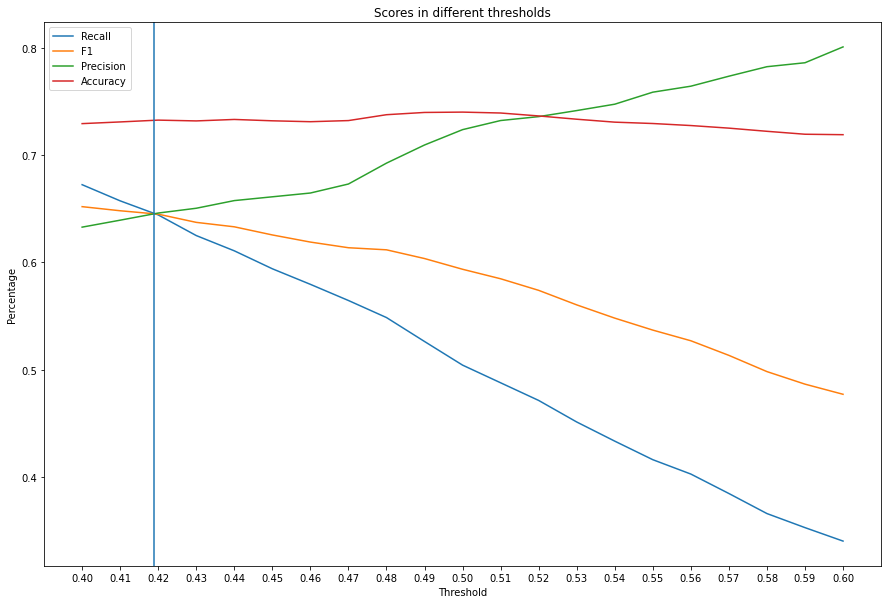

In [92]:
# Prepare data to plot
cols = list(result_score.columns)[1:]
label_name = ["Recall", "F1", "Precision", "Accuracy"]
dict1 = dict(zip(label_name,cols))

# Plot
fig,ax = plt.subplots(figsize=(15,10), sharex=True)

for score, col in dict1.items():
    sns.lineplot(data=result,
                 x='param_logit__threshold',
                 y=col,
                 label=score,
                 ax=ax)
ax.set(title="Scores in different thresholds",
       xlabel="Threshold",
       ylabel='Percentage',
       xticks=np.arange(0.4,0.61,0.01))
plt.axvline(0.419)
plt.legend()
plt.show()

The most balance point maximize all the score would be at 0.419 threshold (at the vertical line in the plot) where is the point that f1-score is about 0.65 which equals to other models, so my final model will look like this

In [93]:
# Build the final model
final_model = Pipeline([
    ('Transform', trans),
    ('Model', Thresholder(LogisticRegression(max_iter=200), threshold=0.419))
]).fit(train_x, train_y)

# Test with test data set and score
pred_y = final_model.predict(test_x)
print(f'ACC: {accuracy_score(test_y,pred_y)}')
print(f'Precision: {precision_score(test_y, pred_y)}')
print(f'Recall: {recall_score(test_y, pred_y)}')
print(f'F1-score" {f1_score(test_y, pred_y)}')

ACC: 0.731286795626577
Precision: 0.6567844925883695
Recall: 0.6301969365426696
F1-score" 0.6432160804020101
